In [1]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime
import numpy as np
import openpyxl
import backtest as bt

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as st
from statsmodels.regression.rolling import RollingOLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

# Purpose of the Notebook

Get monthly valuation-based premium/discount label and implement timing strategy

# Step 1: Obtain Historical Mean and Assign Premium/Discount Tag

Note we can set up a 1 s.d. wide tolerance range to account for valuation levels within normal range

In [2]:
def hist_valuation(s,window = 120, stdtol = 1):
    s_mean = s.rolling(window, min_periods=1).mean()
    if stdtol is not None:
        thresh = s.rolling(window, min_periods=1).std() * stdtol
    else:
        thresh = 0
    diff = s-s_mean

    neutral_mask = abs(diff)<thresh
    premium = diff.index[np.where(diff[~neutral_mask]>0)]
    neutral = diff.index[np.where(diff[neutral_mask])]
    discount = diff.index[np.where(diff[~neutral_mask]<0)]
    
    s = s.to_frame()
    s['tag'] = np.nan
    s.loc[premium,'tag'] = 'premium'
    s.loc[discount,'tag'] = 'discount'
    s.loc[neutral, 'tag'] = 'neutral'
    return s['tag']

In [3]:
rp_monthly, rp_tag, rp_tag1, rp_tag05 = {}, {}, {}, {}

# equity risk premium
hw2 = pd.read_pickle('data/monthly_data_hw2.pickle')
rp_monthly["Equity"] = (1/hw2['CAPE'] - hw2['10Y'])
rp_tag['Equity'] = hist_valuation(rp_monthly['Equity'],120,0)
rp_tag1['Equity'] = hist_valuation(rp_monthly['Equity'],120,1)
rp_tag05['Equity'] = hist_valuation(rp_monthly['Equity'],120,0.5)

# bond risk premium
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2021, 2, 27)
rp_monthly["Bond"] = web.DataReader('THREEFYTP10', 'fred', start, end)['THREEFYTP10']
bond_log = np.log(1+rp_monthly["Bond"]/100)
rp_monthly["Bond"] = bond_log.groupby(pd.Grouper(freq='M')).sum()
rp_tag['Bond'] = hist_valuation(rp_monthly['Bond'],120,0)
rp_tag1['Bond'] = hist_valuation(rp_monthly['Bond'],120,1)
rp_tag05['Bond'] = hist_valuation(rp_monthly['Bond'],120,0.5) 

# betting against beta / Low Risk
bab = pd.read_excel('data/Betting Against Beta Equity Factors Monthly.xlsx', sheet_name='BAB Factors', skiprows=18)
bab = bab.set_index('DATE')
bab.drop('Unnamed: 30', axis=1, inplace=True)
bab.index = pd.to_datetime(bab.index)
bab = bab.loc[:bab.last_valid_index(), :]
rp_monthly['Low Risk'] = bab['USA']
rp_tag['Low Risk'] = hist_valuation(rp_monthly['Low Risk'], 120, 0)
rp_tag1['Low Risk'] = hist_valuation(rp_monthly['Low Risk'], 120, 1)
rp_tag05['Low Risk'] = hist_valuation(rp_monthly['Low Risk'], 120, 0.5)

start = datetime.date(1990,1,1)
end = datetime.date(2021,2,1)
ff_daily = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start,end).read()[0]
# value
rp_monthly['Value'] = ff_daily['HML']
rp_tag['Value'] = hist_valuation(rp_monthly['Value'], 120, 0.)
rp_tag1['Value'] = hist_valuation(rp_monthly['Value'], 120, 1)
rp_tag05['Value'] = hist_valuation(rp_monthly['Value'], 120, 0.5)

# momentum
momentum = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor',start,end).read()[0]
rp_monthly['Momentum'] = momentum['Mom   ']
rp_tag['Momentum'] = hist_valuation(rp_monthly['Momentum'], 120, 0.)
rp_tag1['Momentum'] = hist_valuation(rp_monthly['Momentum'], 120, 1)
rp_tag05['Momentum'] = hist_valuation(rp_monthly['Momentum'], 120, 0.5)

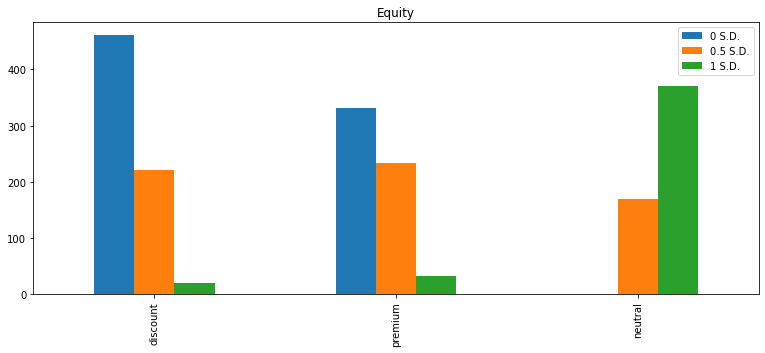

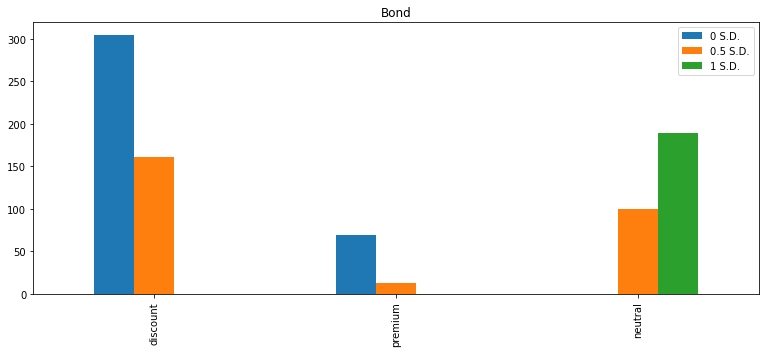

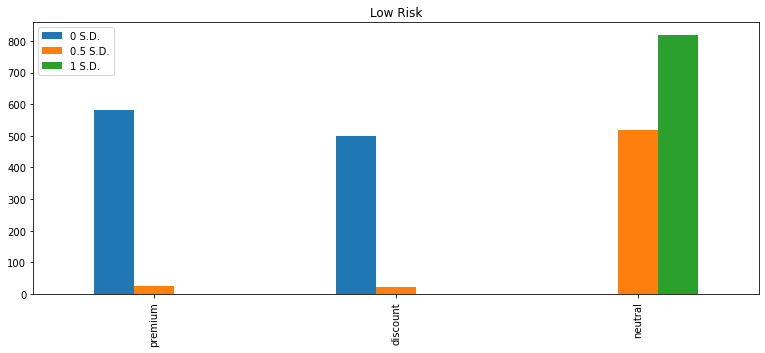

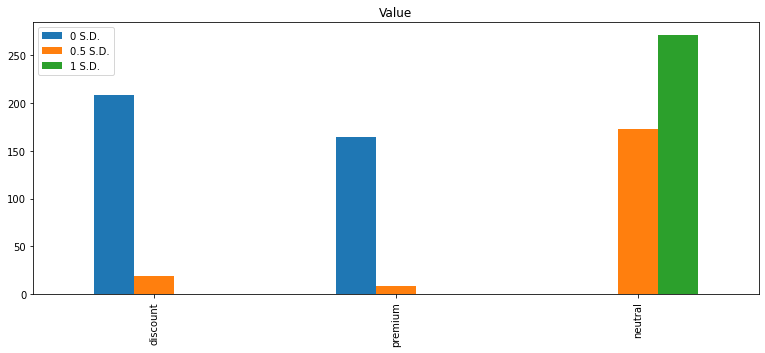

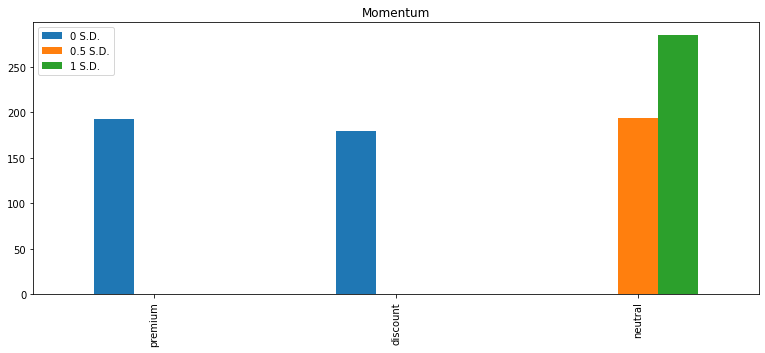

In [4]:
for c in rp_tag.keys():
    temp = pd.concat([rp_tag[c].value_counts(),rp_tag05[c].value_counts(),rp_tag1[c].value_counts()],axis=1)
    temp.columns = ['0 S.D.', '0.5 S.D.', '1 S.D.']
    temp.plot(kind='bar',title = c, legend = True, figsize = (13,5));

In [5]:
# for value, momentum, and BAB, we will directly use the L/S portfolios introduced by the authors
# for equity and bond, we will use the index for 30 year horizon

stock = pd.read_csv('data/S&P 500 Total Return Index.csv',index_col=0).iloc[2:,1]
stock = stock.astype('float')
stock.index = pd.to_datetime(stock.index)
stock = stock.pct_change().apply(lambda x: np.log(1+x))
stock = stock.groupby(pd.Grouper(freq='M')).sum()

bond = pd.read_csv('data/DGS3.csv',index_col=0)
bond.loc[bond['DGS3']=='.'] = 0
bond = pd.to_numeric(bond['DGS3'], errors = 'ignore').dropna()
bond = (1+bond).apply(np.log)/360/100
bond.index = pd.to_datetime(bond.index)
bond = bond.groupby(pd.Grouper(freq='M')).sum()

In [6]:
def log_ret(x):
    return np.log(1+x)
rtn_mat = pd.concat([stock,bond,
           bab['USA'].apply(log_ret)],axis=1)
rtn_mat.columns = list(rp_tag.keys())[:3]
rtn_mat = rtn_mat.loc['1990/1/1':'2020/10/31']
rtn_mat['Value'] = (ff_daily['HML'].loc['1990/1/1':'2020/10/31']/100).apply(log_ret).values
rtn_mat['Momentum'] = (momentum['Mom   '].loc['1990/1/1':'2020/10/31']/100).apply(log_ret).values

# Step 2: Tag-Based Allocation

- Long only (Mean reversion vs. Momentum)
 - Premium: 10% vs. 40%
 - Neutral: 25%
 - Discount: 40% vs. 10% 
 
- Long/Short
 - Premium: -10% vs. 30%
 - Neutral: 10%
 - Discount: 30% vs. -10%

In [7]:
rp_ = {}
for c in rp_tag.keys():
    rp_[c] = rp_tag[c].loc['1990/1/1':'2020/10/31'].fillna('neutral').values
rp_ = pd.DataFrame(rp_,index = rp_tag['Equity'].loc['1990/1/1':'2020/10/31'].index)

In [8]:
long_only_map = {'premium': 0.1, 'neutral': 0.25, 'discount': 0.4}

weights = rp_.replace(long_only_map)
weights = weights.divide(weights.sum(axis=1),axis=0)

In [9]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 21,
                        data_time_step_days = 21)

In [10]:
simulator = bt.Simulator("Valuation Timing", initial_book_size=1)
weights = simulator.add_weights_lag(weights, lag=0)
tc_coeff=np.array([0.0005,0.002,0.0025,0.0025,0.0025])
hc_coeff = np.array([0.,0.0075, 0.01, 0.01, 0.014])
vt_V_t_m, vt_log_ret_m, vt_turnover_df_m = simulator.cal_pnl(weights, 
                                                          rtn_mat, 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

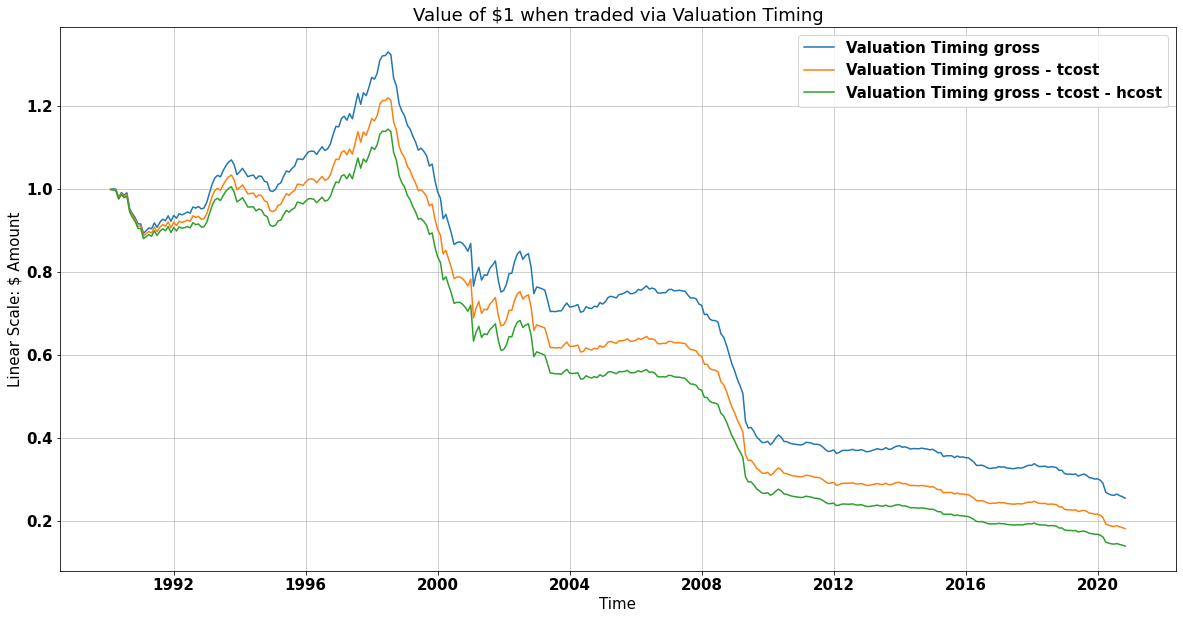

In [13]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=vt_V_t_m, 
                    strategy_name="Valuation Timing", 
                    initial_book_size=1, 
                    scale= 'linear')

In [12]:
rtn_mat['rf_ret'] = rtn_mat['Bond']
indicator = bt.Indicator()
stats = indicator.agg_stats(vt_log_ret_m, 
                               rtn_mat, 
                               vt_V_t_m,
                               vt_turnover_df_m)
visualizer.show_stats(stats)

                                                            Mean Annualized Performance Statistics
+----------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                        |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|----------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Valuation Timing gross                 |          -0.85 |         -4.43 |             6.13 |         497.65 |       -0.7 |       1.09 |             -80.79 |
| Valuation Timing gross - tcost         |          -1.03 |         -5.54 |             6.11 |         497.65 |       -0.7 |       1.09 |             -85.11 |
| Valuation Timing gross - tcost - hcost |          -1.16 |         -6.39 |             6.13 |         497

In [14]:
long_only_map = {'premium': 0.4, 'neutral': 0.25, 'discount': 0.1}

weights = rp_.replace(long_only_map)
weights = weights.divide(weights.sum(axis=1),axis=0)

In [15]:
simulator = bt.Simulator("Valuation Timing", initial_book_size=1)

tc_coeff=np.array([0.0005,0.002,0.0025,0.0025,0.0025])
hc_coeff = np.array([0.,0.0075, 0.01, 0.01, 0.014])
vt1_V_t_m, vt1_log_ret_m, vt1_turnover_df_m = simulator.cal_pnl(weights, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

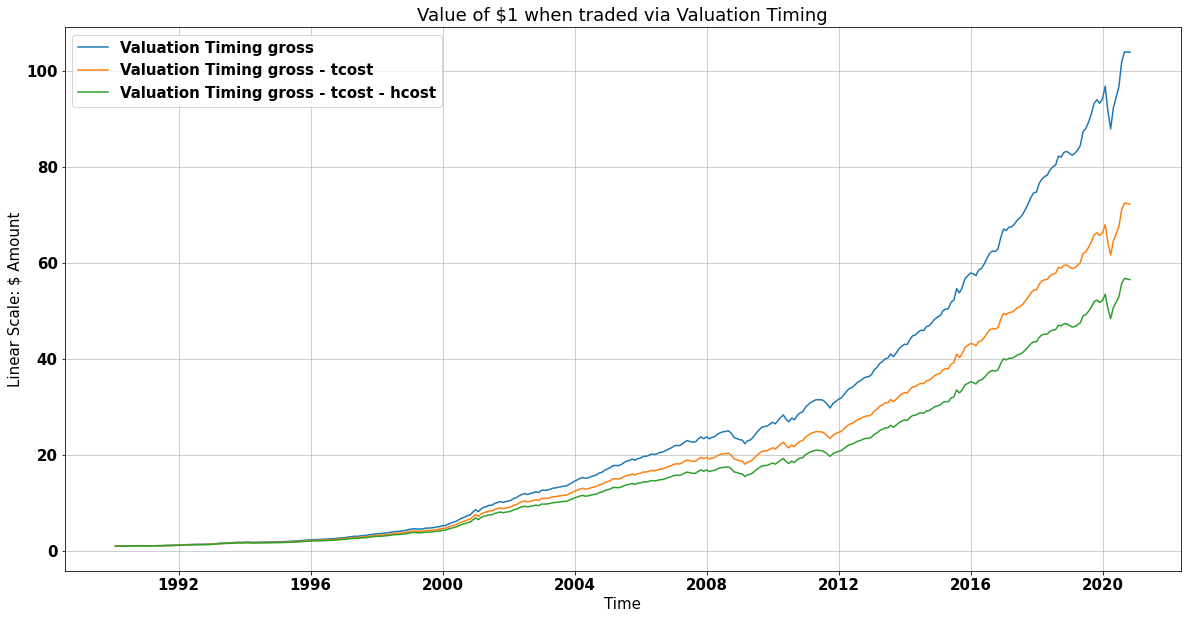

In [16]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=vt1_V_t_m, 
                    strategy_name="Valuation Timing", 
                    initial_book_size=1, 
                    scale= 'linear')

In [17]:
indicator = bt.Indicator()
stats = indicator.agg_stats(vt1_log_ret_m, 
                               rtn_mat, 
                               vt1_V_t_m,
                               vt1_turnover_df_m)
visualizer.show_stats(stats)

                                                            Mean Annualized Performance Statistics
+----------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                        |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|----------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Valuation Timing gross                 |           2.74 |         15.1  |             5.57 |         550.02 |      -0.04 |       0.21 |             -10.87 |
| Valuation Timing gross - tcost         |           2.5  |         13.92 |             5.57 |         550.02 |      -0.05 |       0.22 |             -11.36 |
| Valuation Timing gross - tcost - hcost |           2.34 |         13.12 |             5.56 |         550

In [18]:
long_short_map = {'premium': 0.3, 'neutral': 0.1, 'discount': -0.1}

weights = rp_.replace(long_short_map)
weights = weights.divide(weights.sum(axis=1),axis=0)

In [19]:
simulator = bt.Simulator("Valuation Timing - L/S", initial_book_size=1)
weights = simulator.add_weights_lag(weights, lag=0)
tc_coeff=np.array([0.0005,0.002,0.0025,0.0025,0.0025])
hc_coeff = np.array([0.,0.0075, 0.01, 0.01, 0.014])
vt_V_t_m, vt_log_ret_m, vt_turnover_df_m = simulator.cal_pnl(weights, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

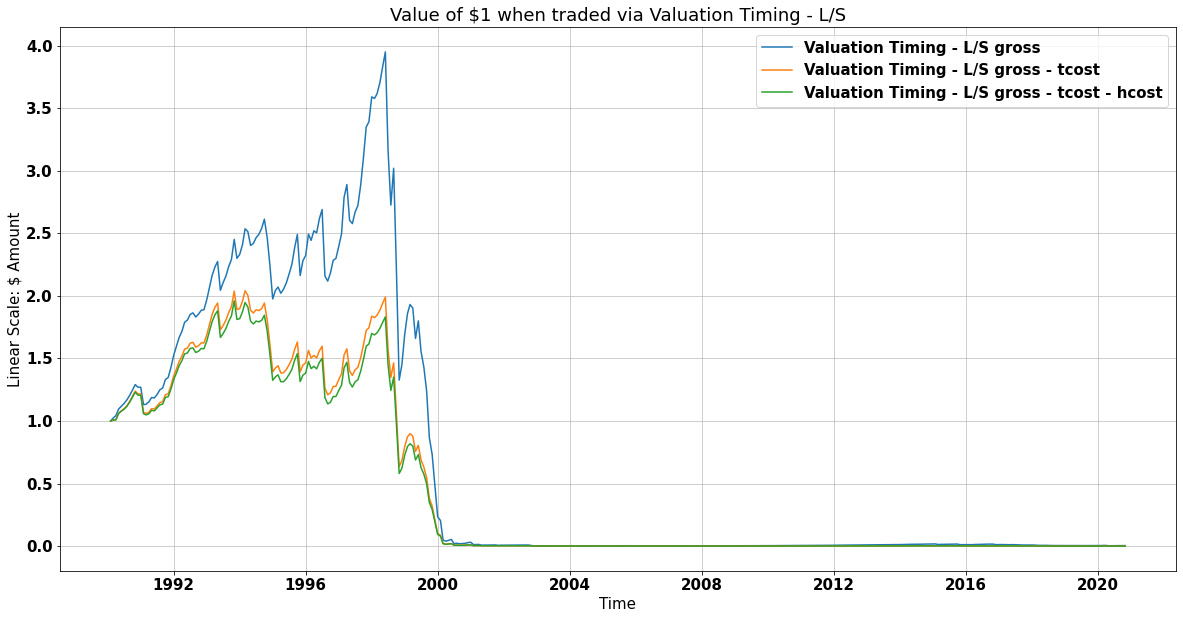

In [20]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=vt_V_t_m, 
                    strategy_name="Valuation Timing - L/S", 
                    initial_book_size=1, 
                    scale= 'linear')

In [21]:
indicator = bt.Indicator()
stats = indicator.agg_stats(vt_log_ret_m, 
                               rtn_mat, 
                               vt_V_t_m,
                               vt_turnover_df_m)
visualizer.show_stats(stats)

                                                            Mean Annualized Performance Statistics
+----------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                              |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|----------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Valuation Timing - L/S gross                 |          -0.43 |        -17.83 |            39.84 |        4341.7  |      -0.84 |       1.03 |             -99.96 |
| Valuation Timing - L/S gross - tcost         |          -0.6  |        -26.21 |            39.92 |        4341.7  |      -0.82 |       1    |             -99.99 |
| Valuation Timing - L/S gross - tcost - hcost |          -0.61 |        -27

In [22]:
long_short_map = {'premium': -0.1, 'neutral': 0.1, 'discount': 0.3}

weights = rp_.replace(long_short_map)
weights = weights.divide(weights.sum(axis=1),axis=0)

In [23]:
simulator = bt.Simulator("Valuation Timing - L/S", initial_book_size=1)

tc_coeff=np.array([0.0005,0.002,0.0025,0.0025,0.0025])
hc_coeff = np.array([0.,0.0075, 0.01, 0.01, 0.014])
vt1_V_t_m, vt1_log_ret_m, vt1_turnover_df_m = simulator.cal_pnl(weights, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

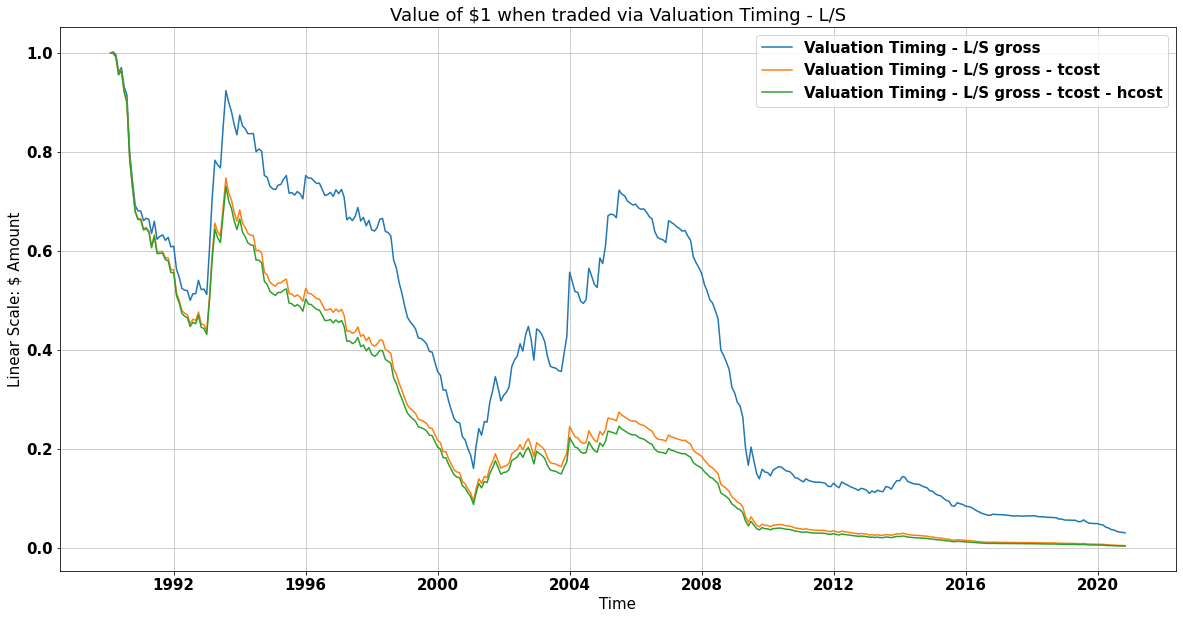

In [24]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=vt1_V_t_m, 
                    strategy_name="Valuation Timing - L/S", 
                    initial_book_size=1, 
                    scale= 'linear')

In [25]:
indicator = bt.Indicator()
stats = indicator.agg_stats(vt1_log_ret_m, 
                           rtn_mat, 
                           vt1_V_t_m,
                           vt1_turnover_df_m)
visualizer.show_stats(stats)

                                                            Mean Annualized Performance Statistics
+----------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                              |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|----------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Valuation Timing - L/S gross                 |          -0.61 |        -11.4  |            19.01 |        3067.21 |       0.41 |       0.6  |             -97    |
| Valuation Timing - L/S gross - tcost         |          -0.93 |        -17.79 |            18.33 |        3067.21 |       0.38 |       0.58 |             -99.58 |
| Valuation Timing - L/S gross - tcost - hcost |          -0.97 |        -18